In [1]:
!pip install captum

Image 'dog.jpg' loaded and transformed successfully.
Visualizing Grad-CAM...


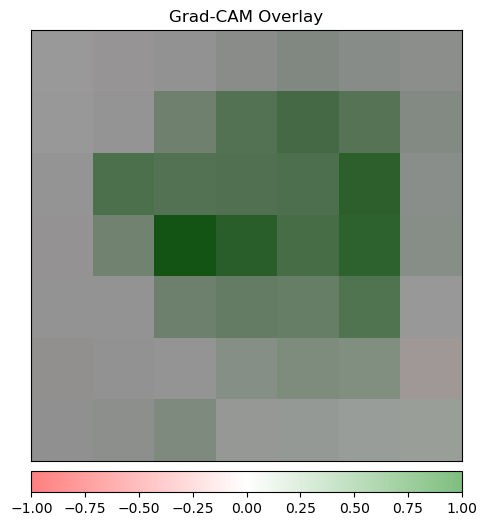

2. Grad-CAM implemented successfully.

Visualizing GradientSHAP...


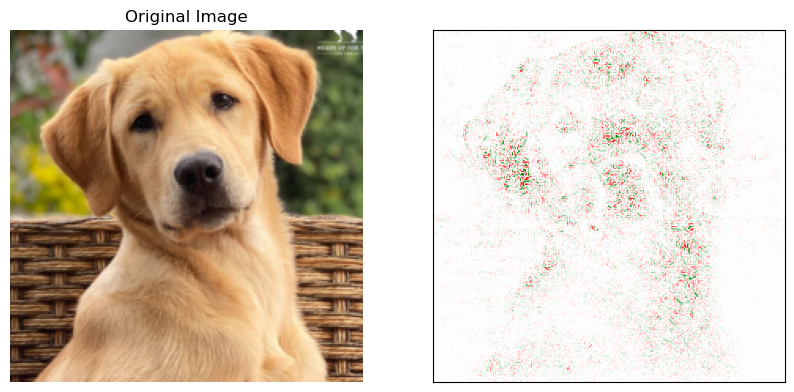

3. SHAP (GradientSHAP) implemented successfully.

Visualizing Smoother SHAP with NoiseTunnel...


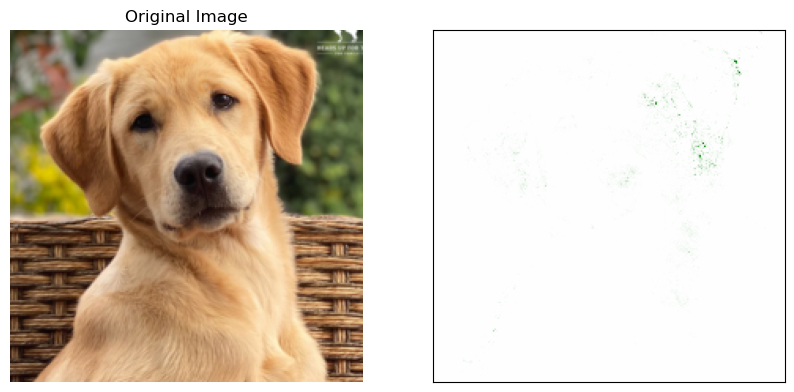

4. Smoother SHAP with NoiseTunnel implemented successfully.

5. Influence Function section is a conceptual placeholder.

---
XAI methods notebook structure is ready.
The next major step is to adapt this pipeline for the skin cancer model.
---



In [2]:
# feature/TP-31-xai-methods

# # 1. Setup and Data Loading
#
# In this section, we'll import necessary libraries, load a pre-trained model,
# and prepare the dataset for our initial XAI experiments.

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerGradCam, GradientShap, NoiseTunnel
from captum.attr import visualization as viz

# --- Load a pre-trained model ---
# Using a standard pre-trained model like ResNet50 is great for development.
# The 'weights' parameter is the modern way to specify pre-trained models.
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval()

# --- Image Preprocessing Pipeline ---
# This pipeline resizes, crops, and normalizes the image so it's ready for the model.
# Normalization is crucial for the model's performance but makes the image hard to view directly.
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Load a Local Image ---
# Loading a local file is more reliable than using a web URL.
# Note: The path '../data/dog.jpg' assumes your notebook is in a subfolder
# and the 'data' folder is one level up. Adjust if your structure is different.
try:
    img = Image.open('../data/dog.jpg')
    input_tensor = transform(img).unsqueeze(0)
    print("Image 'dog.jpg' loaded and transformed successfully.")

    # --- Create a Clean, Un-normalized Version for Display ---
    # We reverse the normalization process on our tensor to create a version
    # that we can correctly display with matplotlib.
    std_devs = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    means = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    unnormalized_tensor = input_tensor.squeeze(0) * std_devs + means

except FileNotFoundError:
    print("---")
    print("ERROR: Could not find '../data/dog.jpg'.")
    print("Please check that the file exists and the path is correct.")
    print("---")


# # 2. Grad-CAM Implementation
#
# Grad-CAM highlights the regions of the image that were most important for the model's
# decision. We'll visualize it as a heatmap overlaid on the original image.

# Define the layer for Grad-CAM. For ResNet, 'layer4' is the last convolutional block.
layer_gc = LayerGradCam(model, model.layer4)

# Generate the attribution map. The target '207' corresponds to 'golden_retriever'.
attribution_gc = layer_gc.attribute(input_tensor, target=207)

# --- Visualize the Grad-CAM result as a proper overlay ---
print("Visualizing Grad-CAM...")

# THE FIX: We use np.expand_dims to add a 3rd dimension to the 2D heatmap.
# This changes its shape from (H, W) to (H, W, 1), which the function expects.
attribution_map = np.expand_dims(attribution_gc.squeeze().cpu().detach().numpy(), axis=2)

viz.visualize_image_attr(attribution_map,
                         np.transpose(unnormalized_tensor.cpu().detach().numpy(), (1, 2, 0)),
                         method='blended_heat_map',
                         sign='all',
                         show_colorbar=True,
                         title='Grad-CAM Overlay')
plt.show()
print("2. Grad-CAM implemented successfully.")


# # 3. SHAP (GradientSHAP) Implementation
#
# SHAP explains a prediction by assigning an importance value to each input feature (pixel).
# Red pixels pushed the model TOWARDS the prediction, Green pixels pushed it AWAY.

gradient_shap = GradientShap(model)

# Generate SHAP attributions.
# Baselines define the "default" or "background" image to compare against.
rand_img_dist = torch.cat([input_tensor * 0, input_tensor * 1])
attribution_gs = gradient_shap.attribute(input_tensor,
                                         n_samples=50,
                                         stdevs=0.0001,
                                         baselines=rand_img_dist,
                                         target=207)

# --- Visualize the SHAP result alongside the clean original image ---
print("\nVisualizing GradientSHAP...")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Display the clean, un-normalized image
axes[0].imshow(np.transpose(unnormalized_tensor.cpu().detach().numpy(), (1, 2, 0)))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the SHAP attribution map
viz.visualize_image_attr(np.transpose(attribution_gs.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                         sign="all",
                         plt_fig_axis=(fig, axes[1]))
axes[1].set_title('GradientSHAP')
plt.show()
print("3. SHAP (GradientSHAP) implemented successfully.")


# # 4. Smoother SHAP using NoiseTunnel
#
# NoiseTunnel helps produce a clearer attribution map by averaging the
# results over several noisy versions of the input image.

print("\nVisualizing Smoother SHAP with NoiseTunnel...")
# NoiseTunnel wraps the original attribution method (GradientShap)
nt_shap = NoiseTunnel(gradient_shap)

# THE FIX: For NoiseTunnel, a simpler single baseline (e.g., a black image) is more stable
# than the distribution we used before.
single_black_baseline = torch.zeros_like(input_tensor)

# Generate the attribution using the new, simpler baseline
nt_attribution_gs = nt_shap.attribute(input_tensor,
                                      nt_type='smoothgrad_sq',
                                      n_samples=10,
                                      stdevs=0.2,
                                      baselines=single_black_baseline, # Using the simpler baseline here
                                      target=207)

# --- Visualize the Smoother SHAP result ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.transpose(unnormalized_tensor.cpu().detach().numpy(), (1, 2, 0)))
axes[0].set_title('Original Image')
axes[0].axis('off')

viz.visualize_image_attr(np.transpose(nt_attribution_gs.squeeze().cpu().detach().numpy(), (1, 2, 0)),
                         sign="all",
                         plt_fig_axis=(fig, axes[1]))
axes[1].set_title('Smoother SHAP (NoiseTunnel)')
plt.show()
print("4. Smoother SHAP with NoiseTunnel implemented successfully.")


# # 5. Influence Functions (Conceptual)
#
# This section remains a conceptual placeholder for implementing Influence Functions,
# which is a more advanced technique for tracing model predictions back to specific
# training examples.

def conceptual_influence_function():
    pass # Conceptual function, no action needed

conceptual_influence_function()
print("\n5. Influence Function section is a conceptual placeholder.")

# # 6. Next Steps: Integrating Your Colleague's Model
#
# The code below shows how you would load your custom skin cancer model
# and begin applying the same XAI techniques.

print("\n---")
print("XAI methods notebook structure is ready.")
print("The next major step is to adapt this pipeline for the skin cancer model.")
print("---\n")

# # Example of loading your custom model (currently commented out)
# try:
#     # skin_cancer_model = YourModelClass() # You need to define or import the model's class structure first
#     # skin_cancer_model.load_state_dict(torch.load('../models/xception_skin_cancer.pth'))
#     # skin_cancer_model.eval()
#     # print("Custom skin cancer model would be loaded here.")
#     #
#     # # To apply Grad-CAM, you would need to find the name of the last convolutional layer
#     # # in your Xception model, for example:
#     # # print(skin_cancer_model)
#     # # layer_gc_custom = LayerGradCam(skin_cancer_model, skin_cancer_model.block12.rep[2])
# except Exception as e:
#     print(f"Could not load custom model (this is expected for now): {e}")